# Spatial Interaction Model

Run the spatial interaction model based on the travel times.

In [1]:
# import libraries
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import osmnx as ox

# load helper functions
from spatial_interaction_tools import *

## Load and Process the OD Matrix

Pre-processing of the OD matrix

In [2]:
# read from csv
od_matrix_tokyo = pd.read_pickle('data/tokyo/pt_network_time_scenarios_updated.pkl')

In [3]:
od_matrix_tokyo.columns

Index(['source', 'target', 'drive_time', 'drive_path', 'drive_time_calib',
       'drive_path_calib', 'multilayer_time', 'multilayer_path', 'bus_time',
       'bus_path', 'rail_time', 'rail_path', 'ped_time', 'ped_path', 'rail',
       'bus', 'car', 'motorbike', 'bicycle', 'pedestrian', 'other', 'unknown',
       'total', 'public_transport', 'vehicle', 'total_edit',
       'driving_time_orig', 'driving_time_removed_Ginza',
       'driving_time_removed_Akihabara', 'driving_time_removed_Shinjuku',
       'driving_time_removed_Chuo_dori', 'driving_time_removed_all',
       'driving_time_removed_Ginza_nodes',
       'driving_time_removed_Akihabara_nodes',
       'driving_time_removed_Shinjuku_nodes',
       'driving_time_removed_Chuo_dori_nodes',
       'driving_time_removed_all_nodes', 'driving_path_orig',
       'driving_path_removed_Ginza', 'driving_path_removed_Akihabara',
       'driving_path_removed_Shinjuku', 'driving_path_removed_Chuo_dori',
       'driving_path_removed_all', 'driv

In [5]:
# calculate Oi and Dj
Oi = od_matrix_tokyo.iloc[:, :14].groupby('source').sum().drop(columns = 'target').add_prefix('Oi_')
Dj = od_matrix_tokyo.iloc[:, :14].groupby('target').sum().drop(columns = 'source').add_prefix('Dj_')

# merge with the original dataframe
od_matrix_original = od_matrix_tokyo.merge(
    Oi.iloc[:, -4:-1],
    how = 'left',
    left_on = 'source',
    right_index = True
).merge(
    Dj.iloc[:, -4:-1],
    how = 'right',
    left_on = 'target',
    right_index = True
)

## Doubly Constrained Model

### Calibrate the Model

In [6]:
# dictionary of modes that compete
modes = {
    'modes': ['vehicle', 'public_transport'],
    'cost': ['driving_time_orig', 'multilayer_time'],
    'path': ['driving_path_orig', 'multilayer_path'],
    'observed_flow': ['vehicle', 'public_transport']
}

In [7]:
# run the model
od_matrix_model_db, beta_db = calibrate_model(od_matrix_original, modes, AiBj_init = 0.001, show_log = False)

#### Validation of the Model

In [8]:
# validate the model
print('Total Flows', CalcRSquared(od_matrix_model_db['obs_total_flow'], od_matrix_model_db['pred_total']))
print('Public Transport', CalcRSquared(od_matrix_model_db['public_transport'], od_matrix_model_db['pred_public_transport']))
print('Vehicles', CalcRSquared(od_matrix_model_db['vehicle'], od_matrix_model_db['pred_vehicle']))

Total Flows 0.8482361308002522
Public Transport 0.8317355208347106
Vehicles 0.6617915167603348


In [9]:
plt.rcParams['font.serif']

['DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Times New Roman',
 'Times',
 'Palatino',
 'Charter',
 'serif']

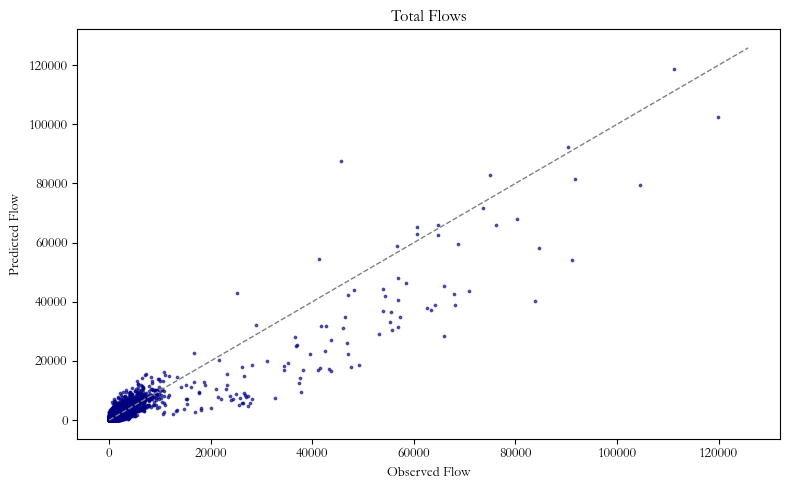

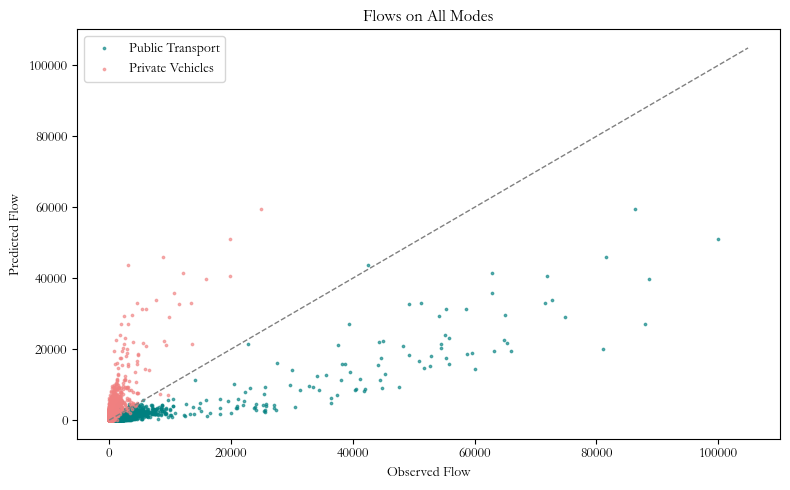

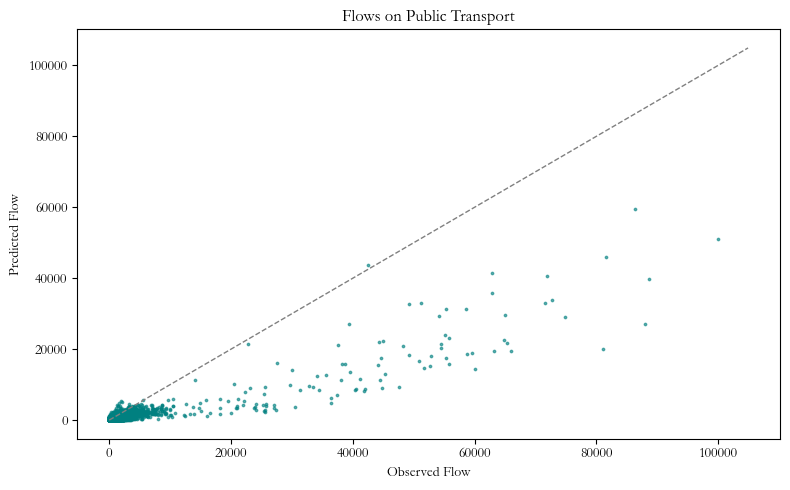

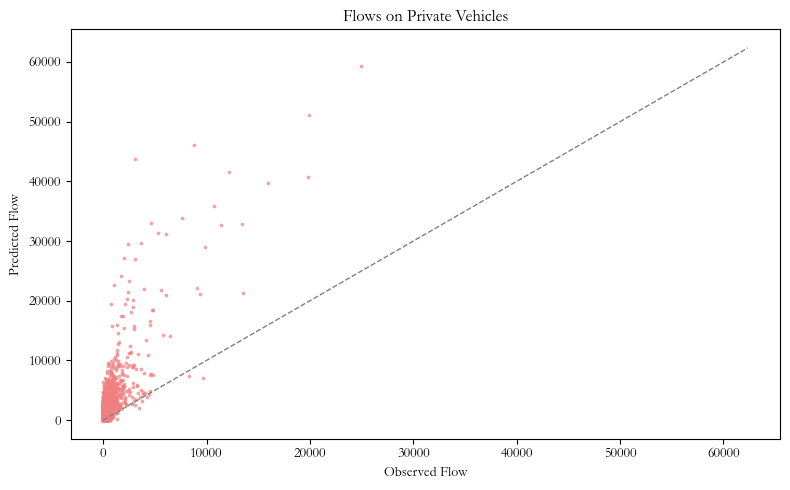

In [10]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

# plot the results for all
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

od_matrix_model_db.plot.scatter(
    x = 'obs_total_flow',
    y = 'pred_total',
    ax = ax,
    s = 3,
    c = 'navy',
    alpha = 0.6
)

# plot diagonal line
ax.plot(
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    color='gray', linestyle='--',
    linewidth = 1
)

# change the axis
ax.set_xlabel('Observed Flow')
ax.set_ylabel('Predicted Flow')
ax.set_title('Total Flows')

plt.tight_layout()
plt.savefig('documents/img/doubly_constrained_flows_total.png', bbox_inches = 'tight')

# plot the results for both
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

# plot for both public transport and private
od_matrix_model_db.plot.scatter(
    x = 'public_transport',
    y = 'pred_public_transport',
    ax = ax,
    s = 3,
    c = 'teal',
    alpha = 0.6,
    label = 'Public Transport'
)
od_matrix_model_db.plot.scatter(
    x = 'vehicle',
    y = 'pred_vehicle',
    ax = ax,
    s = 3,
    c = 'lightcoral',
    alpha = 0.6,
    label = 'Private Vehicles'
)

# plot diagonal line
ax.plot(
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    color='gray', linestyle='--',
    linewidth = 1
)

# change the axis
ax.set_xlabel('Observed Flow')
ax.set_ylabel('Predicted Flow')
ax.set_title('Flows on All Modes')

plt.tight_layout()
plt.savefig('documents/img/doubly_constrained_flows_all_modes.png', bbox_inches = 'tight')

# plot the results for public transport
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

od_matrix_model_db.plot.scatter(
    x = 'public_transport',
    y = 'pred_public_transport',
    ax = ax,
    s = 3,
    c = 'teal',
    alpha = 0.6,
)

# plot diagonal line
ax.plot(
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    color='gray', linestyle='--',
    linewidth = 1
)

# change the axis
ax.set_xlabel('Observed Flow')
ax.set_ylabel('Predicted Flow')
ax.set_title('Flows on Public Transport')

plt.tight_layout()
plt.savefig('documents/img/doubly_constrained_flows_pt.png', bbox_inches = 'tight')

# plot the results for vehicles
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

od_matrix_model_db.plot.scatter(
    x = 'vehicle',
    y = 'pred_vehicle',
    ax = ax,
    s = 3,
    c = 'lightcoral',
    alpha = 0.6,   
)

# plot diagonal line
ax.plot(
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
    color='gray', linestyle='--',
    linewidth = 1
)

# change the axis
ax.set_xlabel('Observed Flow')
ax.set_ylabel('Predicted Flow')
ax.set_title('Flows on Private Vehicles')

plt.tight_layout()
plt.savefig('documents/img/doubly_constrained_flows_vehicles.png', bbox_inches = 'tight')


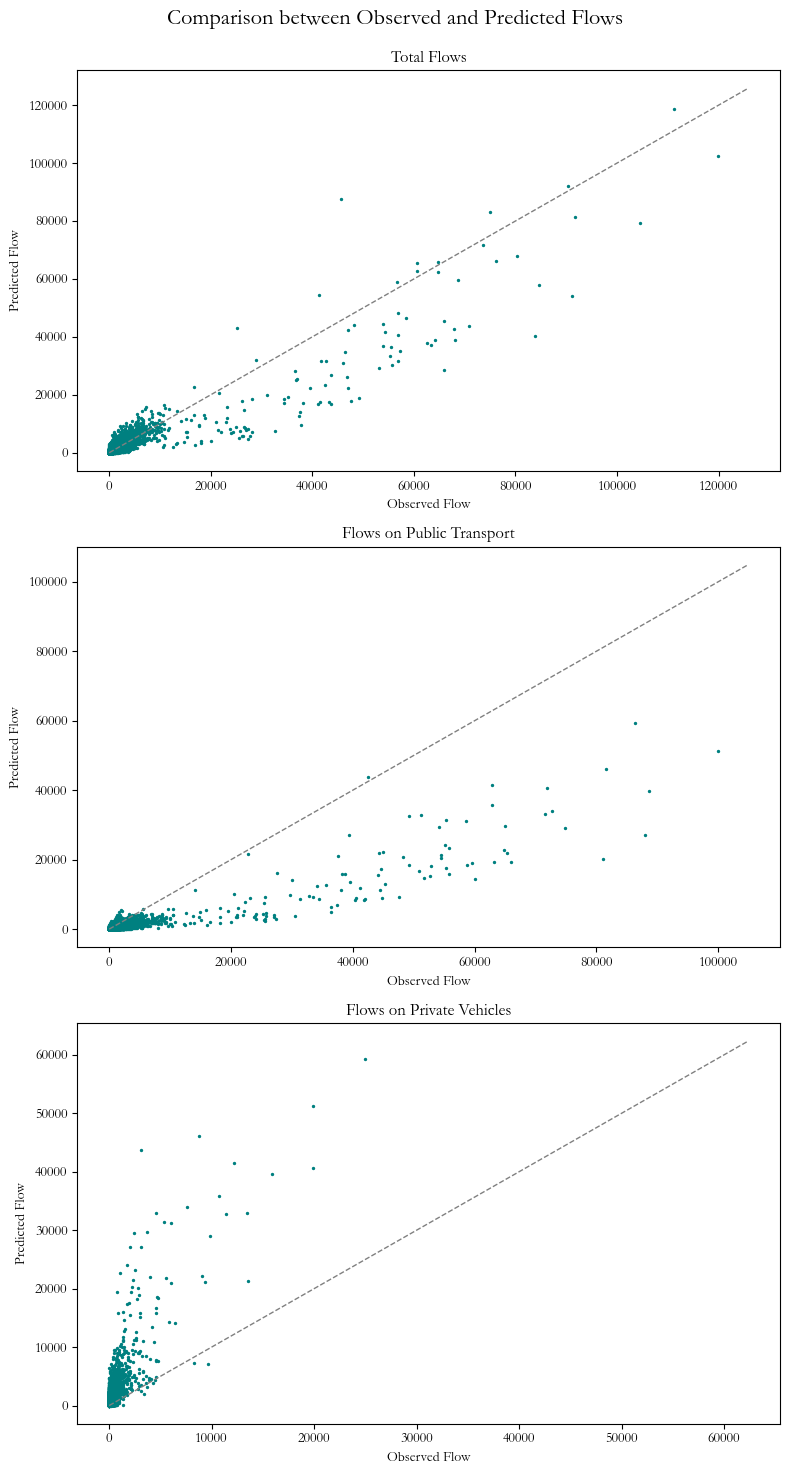

In [11]:

# plot the results
fig, axes = plt.subplots(3, 1, figsize = (8, 15))

od_matrix_model_db.plot.scatter(
    x = 'obs_total_flow',
    y = 'pred_total',
    ax = axes[0],
    s = 2,
    c = 'teal'
)

od_matrix_model_db.plot.scatter(
    x = 'public_transport',
    y = 'pred_public_transport',
    ax = axes[1],
    s = 2,
    c = 'teal'
)

od_matrix_model_db.plot.scatter(
    x = 'vehicle',
    y = 'pred_vehicle',
    ax = axes[2],
    s = 2,
    c = 'teal'
)

# draw the equal line
for ax in axes:
    ax.plot(
        [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
        [0,max(ax.get_xlim()[1], ax.get_ylim()[1])],
        color='gray', linestyle='--',
        linewidth = 1
    )
    # change the axis
    ax.set_xlabel('Observed Flow')
    ax.set_ylabel('Predicted Flow')

# change the titles
axes[0].set_title('Total Flows', fontsize = 12)
axes[1].set_title('Flows on Public Transport', fontsize = 12)
axes[2].set_title('Flows on Private Vehicles', fontsize = 12)
plt.suptitle('Comparison between Observed and Predicted Flows\n', fontsize = 16)

plt.tight_layout()
plt.savefig('documents/img/doubly_constrained_flows.png', bbox_inches = 'tight')

In [12]:
# compare the modal share
od_matrix_original['public_transport'].sum() / (od_matrix_original['public_transport'].sum() + od_matrix_original['vehicle'].sum())

0.898430957151647

### Run for scenarios

In [13]:
scenarios = [c.replace('driving_time_', '') for c in od_matrix_original.columns if 'driving_time' in c]

In [14]:
scenarios

['orig',
 'removed_Ginza',
 'removed_Akihabara',
 'removed_Shinjuku',
 'removed_Chuo_dori',
 'removed_all',
 'removed_Ginza_nodes',
 'removed_Akihabara_nodes',
 'removed_Shinjuku_nodes',
 'removed_Chuo_dori_nodes',
 'removed_all_nodes']

In [15]:
od_matrix_scenarios = {}

# run for multiple scenarios
for s in scenarios:
    # get the model input
    modes_model = modes
    modes_model['cost'] = [f'driving_time_{s}', 'multilayer_time']
    modes_model['path'] = [f'driving_path_{s}', 'multilayer_path']
    print(f'Calculating {s}')
    
    # run the model
    df = calibrate_model(od_matrix_original, modes_model, beta_init = beta_db, AiBj_init = 0.001, calib_beta = False, show_log = False)
    
    # add to dict
    od_matrix_scenarios[s] = df


Calculating orig
Calculating removed_Ginza
Calculating removed_Akihabara
Calculating removed_Shinjuku
Calculating removed_Chuo_dori
Calculating removed_all
Calculating removed_Ginza_nodes
Calculating removed_Akihabara_nodes
Calculating removed_Shinjuku_nodes
Calculating removed_Chuo_dori_nodes
Calculating removed_all_nodes


In [16]:
pt_modal_share = {}
for s in od_matrix_scenarios:
    share = (od_matrix_scenarios[s]['pred_public_transport'].sum()) / (od_matrix_scenarios[s]['pred_total'].sum())
    pt_modal_share[s] = share

pt_modal_share
    

{'orig': 0.4240077172082477,
 'removed_Ginza': 0.42437087563197423,
 'removed_Akihabara': 0.4240077172082477,
 'removed_Shinjuku': 0.4240077172082477,
 'removed_Chuo_dori': 0.42468528174721665,
 'removed_all': 0.42437087563197423,
 'removed_Ginza_nodes': 0.42502157378622785,
 'removed_Akihabara_nodes': 0.4240783130440301,
 'removed_Shinjuku_nodes': 0.4243549620344287,
 'removed_Chuo_dori_nodes': 0.43235743979669067,
 'removed_all_nodes': 0.42544302859187566}

## Doubly Constrained Model without intra-zone flows

In [17]:
od_matrix_inter = od_matrix_original[od_matrix_original['source'] != od_matrix_original['target']].copy()

In [18]:
# run the model
od_matrix_model_db2, beta_db2 = calibrate_model(od_matrix_inter, modes, AiBj_init = 0.001, show_log = False)

In [19]:
od_matrix_scenarios_inter = {}

# run for multiple scenarios
for s in scenarios:
    # get the model input
    modes_model = modes
    modes_model['cost'] = [f'driving_time_{s}', 'multilayer_time']
    modes_model['path'] = [f'driving_path_{s}', 'multilayer_path']
    print(f'Calculating {s}')
    
    # run the model
    df = calibrate_model(od_matrix_inter, modes_model, beta_init = beta_db2, AiBj_init = 0.001, calib_beta = False, show_log = False)
    
    # add to dict
    od_matrix_scenarios_inter[s] = df

# calculate modal share
pt_modal_share_inter = {}
for s in od_matrix_scenarios_inter:
    share = (od_matrix_scenarios_inter[s]['pred_public_transport'].sum()) / (od_matrix_scenarios_inter[s]['pred_total'].sum())
    pt_modal_share_inter[s] = share

pt_modal_share_inter

Calculating orig
Calculating removed_Ginza
Calculating removed_Akihabara
Calculating removed_Shinjuku
Calculating removed_Chuo_dori
Calculating removed_all
Calculating removed_Ginza_nodes
Calculating removed_Akihabara_nodes
Calculating removed_Shinjuku_nodes
Calculating removed_Chuo_dori_nodes
Calculating removed_all_nodes


{'orig': 0.5127206883531051,
 'removed_Ginza': 0.5131489816808497,
 'removed_Akihabara': 0.5127206883531051,
 'removed_Shinjuku': 0.5127206883531051,
 'removed_Chuo_dori': 0.5135124639776008,
 'removed_all': 0.5131489816808497,
 'removed_Ginza_nodes': 0.5139155142025532,
 'removed_Akihabara_nodes': 0.5128010219877966,
 'removed_Shinjuku_nodes': 0.5131294857351977,
 'removed_Chuo_dori_nodes': 0.5225988063817966,
 'removed_all_nodes': 0.5144083774829799}

## Calibration of the speed



In [20]:
# load the network and calculate the average speed
tokyo_drive_network = ox.load_graphml(os.path.join('data', 'tokyo', 'drive_network_updated.graphml'))

In [21]:
# average speed of all roads
mean_speed = sum([d['length'] * d['speed_kph'] for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True)]) / sum([d['length'] for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True)])
print(mean_speed)

39.92581609036763


In [22]:
# the actual mean speed from the census
actual_speed = 19.0

In [23]:
# create column for calibrated speed
od_matrix_original['driving_time_calibrated'] = od_matrix_original['driving_time_orig'] * mean_speed / actual_speed

In [24]:
# set model
modes_calib = modes.copy()
modes_calib['cost'] = ['driving_time_calibrated', 'multilayer_time']

# run 
od_matrix_model_calib, beta_calib = calibrate_model(od_matrix_original, modes_calib, AiBj_init = 0.001, show_log = False)

In [25]:
# validate the model
print('Total Flows', CalcRSquared(od_matrix_model_calib['obs_total_flow'], od_matrix_model_calib['pred_total']))
print('Public Transport', CalcRSquared(od_matrix_model_calib['public_transport'], od_matrix_model_calib['pred_public_transport']))
print('Vehicles', CalcRSquared(od_matrix_model_calib['vehicle'], od_matrix_model_calib['pred_vehicle']))

Total Flows 0.8482689314581723
Public Transport 0.8317661900619694
Vehicles 0.6617680842000807


In [26]:
beta_calib

{'vehicle': 0.11432796416937234, 'public_transport': 0.05784263937814559}

In [27]:
beta_db

{'vehicle': 0.2402136168338647, 'public_transport': 0.0578357349192152}

In [28]:
# modal share for public transport on calibrated network
od_matrix_model_calib['pred_public_transport'].sum() / (od_matrix_model_calib['pred_public_transport'].sum() + od_matrix_model_calib['pred_vehicle'].sum())

0.42394672316666215

In [29]:
# modal share for public transport
od_matrix_model_db['pred_public_transport'].sum() / (od_matrix_model_db['pred_public_transport'].sum() + od_matrix_model_db['pred_vehicle'].sum())

0.42394513884119994

In [30]:
# modal share for public transport
od_matrix_model_db['public_transport'].sum() / (od_matrix_model_db['public_transport'].sum() + od_matrix_model_db['vehicle'].sum())

0.898430957151647

## Spatial interaction using the removed scenarios

Consider the scenarios based on the POI-density based removed scenarios

In [31]:
# load the scenarios
scenarios_time = pd.read_pickle('data/tokyo/travel_time_poi.pkl')

# edit the zone names
for c in ['source', 'target']:
    scenarios_time[c] = scenarios_time[c].str.replace('zone_', '').astype(int)

In [32]:
scenarios_time

,source,target,driving_time_0,driving_time_10,driving_time_20,driving_time_30,driving_time_40,driving_time_50,driving_time_60,driving_time_70,...,driving_path_210,driving_path_220,driving_path_230,driving_path_240,driving_path_250,driving_path_260,driving_path_270,driving_path_280,driving_path_290,driving_path_300
0,430,430,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,[zone_430],[zone_430],[zone_430],[zone_430],[zone_430],[zone_430],[zone_430],[zone_430],[zone_430],[zone_430]
1,430,34,13.785000,18.341667,14.080000,12.681667,12.681667,12.548333,12.548333,12.548333,...,"[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3..."
2,430,122,12.628333,21.440000,18.785000,17.193333,17.193333,16.625000,16.625000,16.625000,...,"[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3..."
3,430,131,13.666667,19.565000,16.976667,16.976667,16.976667,16.976667,16.976667,16.976667,...,"[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3..."
4,430,348,22.788333,34.728333,20.423333,20.423333,20.393333,20.273333,20.273333,20.273333,...,"[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3...","[zone_430, 8269971143, 307676170, 307676147, 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,233,512,4.721667,23.255000,18.975000,17.460000,14.275000,14.275000,14.275000,14.275000,...,"[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ..."
13221,233,513,4.721667,23.981667,20.350000,18.686667,16.653333,16.653333,16.653333,16.653333,...,"[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 1701041438, 1142397072, ...","[zone_233, 295422578, 

In [33]:
od_matrix_pois = od_matrix_original.merge(
    scenarios_time,
    on = ['source', 'target'],
    how = 'left'
)

In [34]:
od_matrix_poi_density = {}

# set the scenarios
density = [str(d) for d in range(0, 310, 10)]

# run for multiple scenarios
for s in density:
    # get the model input
    modes_model = modes
    modes_model['cost'] = [f'driving_time_{s}', 'multilayer_time']
    modes_model['path'] = [f'driving_path_{s}', 'multilayer_path']
    print(f'Calculating {s}')
    
    # run the model
    df = calibrate_model(od_matrix_pois, modes_model, beta_init = beta_db, AiBj_init = 0.001, calib_beta = False, show_log = False)
    
    # add to dict
    od_matrix_poi_density[s] = df


Calculating 0
Calculating 10
Calculating 20
Calculating 30
Calculating 40
Calculating 50
Calculating 60
Calculating 70
Calculating 80
Calculating 90
Calculating 100
Calculating 110
Calculating 120
Calculating 130
Calculating 140
Calculating 150
Calculating 160
Calculating 170
Calculating 180
Calculating 190
Calculating 200
Calculating 210
Calculating 220
Calculating 230
Calculating 240
Calculating 250
Calculating 260
Calculating 270
Calculating 280
Calculating 290
Calculating 300


In [35]:
# calculate modal shift
pt_modal_share_poi = {
    'density': [],
    'pt_share': []
}
for n, G in od_matrix_poi_density.items():
    share = (G['pred_public_transport'].sum()) / (G['pred_total'].sum())
    pt_modal_share_poi['density'].append(int(n))
    pt_modal_share_poi['pt_share'].append(share)

pt_modal_share_poi_df = pd.DataFrame(pt_modal_share_poi)
    

In [36]:
# load street length data
street_length = pd.read_csv('data/tokyo/poi_density_street_length.csv')

# merge with length of street
pt_modal_share_merged = pt_modal_share_poi_df.merge(
    street_length,
    left_on = 'density',
    right_on = 'poi_density',
    how = 'left'
)


In [37]:
pt_modal_share_merged

,density,pt_share,poi_density,length_removed,percentage_left
0,0,0.373075,0,4342285.673,0.324301
1,10,0.587703,10,948776.524,0.852362
2,20,0.517035,20,468806.009,0.927049
3,30,0.477984,30,264619.221,0.958823
4,40,0.461184,40,163997.164,0.974481
5,50,0.445738,50,107151.285,0.983326
6,60,0.441682,60,82593.172,0.987148
7,70,0.436701,70,53824.836,0.991624
8,80,0.432930,80,41175.834,0.993593
9,90,0.430787,90,33419.207,0.994800


In [38]:
pt_modal_share

{'orig': 0.4240077172082477,
 'removed_Ginza': 0.42437087563197423,
 'removed_Akihabara': 0.4240077172082477,
 'removed_Shinjuku': 0.4240077172082477,
 'removed_Chuo_dori': 0.42468528174721665,
 'removed_all': 0.42437087563197423,
 'removed_Ginza_nodes': 0.42502157378622785,
 'removed_Akihabara_nodes': 0.4240783130440301,
 'removed_Shinjuku_nodes': 0.4243549620344287,
 'removed_Chuo_dori_nodes': 0.43235743979669067,
 'removed_all_nodes': 0.42544302859187566}

Text(0.5, 1.0, 'Change in the Modal Share by Removing Edges Based on POI Density')

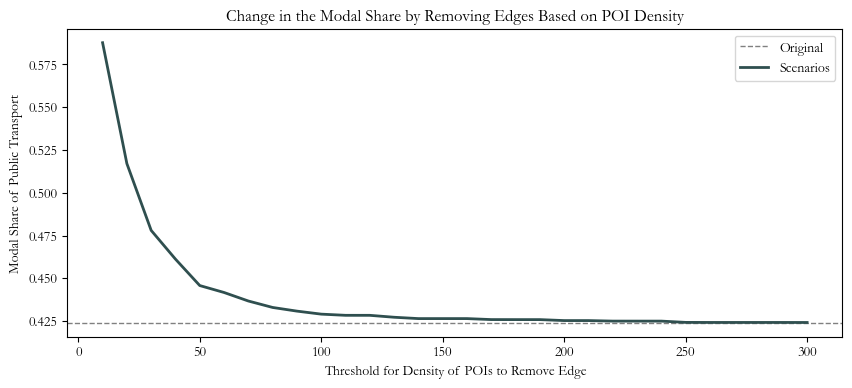

In [39]:
# plot
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

# add horizontal line at original
ax.axhline(
    y = pt_modal_share['orig'], 
    color = 'gray', linestyle='--',
    label = 'Original',
    linewidth = 1
)

pt_modal_share_merged[1:].plot(
    'density', 
    'pt_share', 
    ax = ax,
    color = 'darkslategray',
    linewidth = 2, 
    label = 'Scenarios'
)

# create legend
plt.legend()

# set xticks
ax.set_xticks([0, 50, 100, 150, 200, 250, 300])

# set labels
ax.set_xlabel('Threshold for Density of POIs to Remove Edge')
ax.set_ylabel('Modal Share of Public Transport')

ax.set_title('Change in the Modal Share by Removing Edges Based on POI Density')


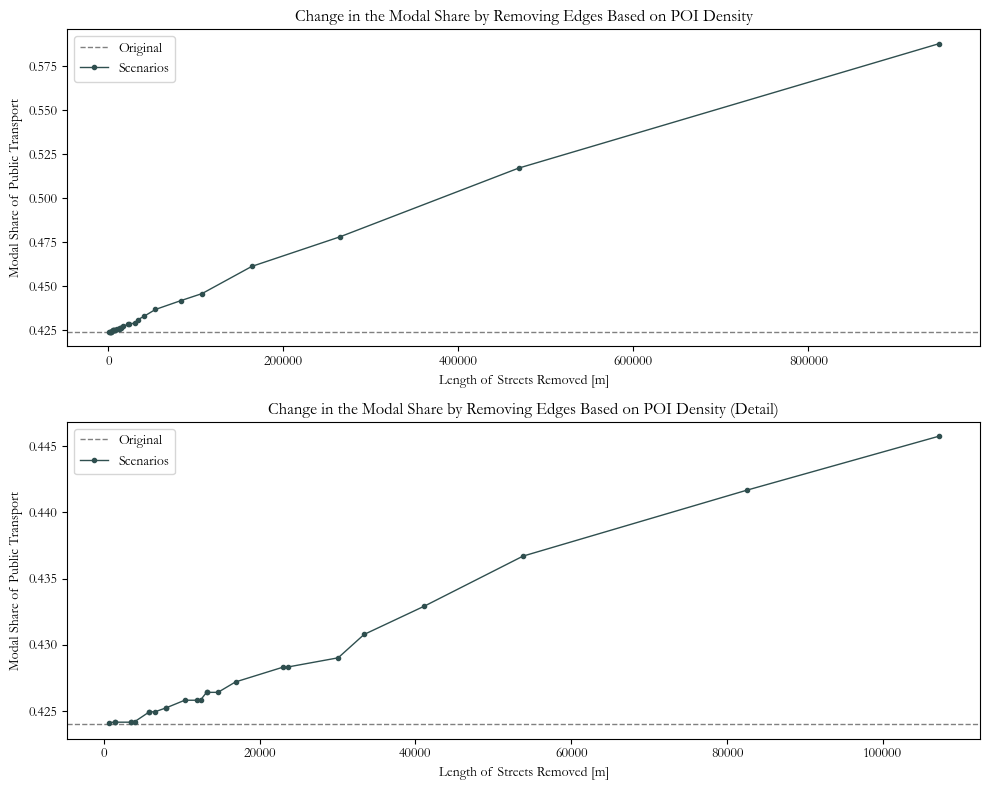

In [40]:
# plot
fig, axes = plt.subplots(2, 1, figsize = (10, 8))

# add horizontal line at original
for ax in axes:
    ax.axhline(
        y = pt_modal_share['orig'], 
        color = 'gray', linestyle='--',
        label = 'Original',
        linewidth = 1
    )

pt_modal_share_merged[1:].plot(
    'length_removed', 
    'pt_share',
    ax = axes[0],
    color = 'darkslategray',
    linewidth = 1, 
    label = 'Scenarios',
    marker = 'o',
    markersize = 3
)

pt_modal_share_merged[5:].plot(
    'length_removed', 
    'pt_share',
    ax = axes[1],
    color = 'darkslategray',
    linewidth = 1, 
    label = 'Scenarios',
    marker = 'o',
    markersize = 3
)

for ax in axes:

    # create legend
    ax.legend()

    # set labels
    ax.set_xlabel('Length of Streets Removed [m]')
    ax.set_ylabel('Modal Share of Public Transport')

axes[0].set_title('Change in the Modal Share by Removing Edges Based on POI Density')
axes[1].set_title('Change in the Modal Share by Removing Edges Based on POI Density (Detail)')


plt.tight_layout()


## Calculate the Flow on each segment of the network

Using the results we have, calculate the total emissions.

-> do it in a different file

In [41]:
# save the list of df as a pickle

with open('data/tokyo/od_matrix_scenarios_poi.pkl', 'wb') as f:
    pickle.dump(od_matrix_poi_density, f)

In [42]:

with open('data/tokyo/od_matrix_scenarios_real.pkl', 'wb') as f:
    pickle.dump(od_matrix_scenarios, f)